## Making Model Movies

In this notebook, I am reading in the surface snapshots of theta, salt, uvel, and vvel and creating movies of each variable over the course of the model run. I then calculate vorticity and relative vorticity and generate movies of them. 

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import vertical
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from datetime import datetime, timedelta

In [31]:
# Define a path to this lesson's folder
# lesson_folder = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 14'
lesson_folder = '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2'

In [32]:
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 9',
                                 'Greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [33]:
depth = bathy
delR = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
          1.93,    2.20,    2.50,    2.84,   3.21,
          3.63,    4.10,    4.61,    5.18,   5.79,
          6.47,    7.20,    7.98,    8.83,   9.73,
         10.69,   11.70,   12.76,   13.87,  15.03,
         16.22,   17.45,   18.70,   19.97,  21.27,
         22.56,   23.87,   25.17,   26.46,  27.74,
         29.00,   30.24,   31.45,   32.65,  33.82,
         34.97,   36.09,   37.20,   38.29,  39.37])
hfacC_file = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 13/hFacC.data'
hfacC = np.fromfile(hfacC_file, '>f4').reshape(45, 540, 720)
land_mask = (hfacC[0, :, :] == 0)   # True = land/dry, False = ocean

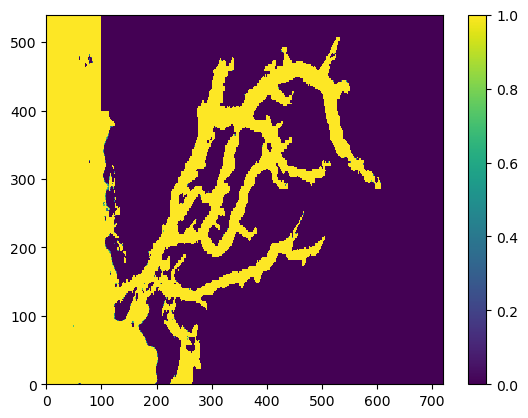

In [34]:
plt.pcolormesh(hfacC[10,:,:], vmax = 1)
plt.colorbar()

In [35]:
# testing a code block that reads the iter_step from the files

ny, nx = 540, 720

def read_surface_conditions_from_file(lesson_folder):

    theta_list = []
    salt_list  = []
    uvel_list  = []
    vvel_list  = []
    iter_list  = []

    # reading in all theta/salt files 
    ts_dir = os.path.join(lesson_folder, "TS_surf_daily_mean")
    
    # glob finds all output files for this diagnostic (*.data) so we can loop through timesteps 
    ts_files = sorted(glob.glob(os.path.join(ts_dir, "*.data")))

    for ts_file in ts_files:
        # get the iteration number from the filename
        iter_str = os.path.basename(ts_file).split(".")[-2]
        i = int(iter_str)

        # do the same for the uvel/vvel files
        uv_file = os.path.join(lesson_folder, "UV_surf_daily_mean", f"UV_surf_daily_mean.{iter_str}.data")

        if not os.path.isfile(uv_file):
            print(f"Skipping {i}: UV file missing")
            continue

        # read the theta and salt from the file
        TS = np.fromfile(ts_file, ">f4").reshape(2, ny, nx)
        theta_list.append(TS[0])
        salt_list.append(TS[1])

        # read the uvel and vvel from the file
        UV = np.fromfile(uv_file, ">f4").reshape(2, ny, nx)
        uvel_list.append(UV[0])
        vvel_list.append(UV[1])

        iter_list.append(i)

    # turn the lists into arrays
    theta = np.array(theta_list)
    salt  = np.array(salt_list)
    uvel  = np.array(uvel_list)
    vvel  = np.array(vvel_list)
    iters = np.array(iter_list)

    return theta, salt, uvel, vvel, iters


# calling the function 
THETA, SALT, UVEL, VVEL, iters = read_surface_conditions_from_file(lesson_folder)

# test for sanity check
print("Shapes:", THETA.shape, UVEL.shape)
print("First iterations:", iters[:5])
print("Last iterations:", iters[-5:])


Shapes: (533, 540, 720) (533, 540, 720)
First iterations: [10 30 50 70 90]
Last iterations: [279000 279720 280440 281160 281880]


In [36]:
# printing the max/min to help with plotting colorbars 

print("THETA min/max:", THETA.min(), THETA.max())
print("SALT  min/max:", SALT.min(),  SALT.max())
print("UVEL  min/max:", UVEL.min(),  UVEL.max())
print("VVEL  min/max:", VVEL.min(),  VVEL.max())

THETA min/max: -19.702932 20.0
SALT  min/max: 0.0 35.330864
UVEL  min/max: -2.3553846 2.5405633
VVEL  min/max: -1.9670106 2.3326457


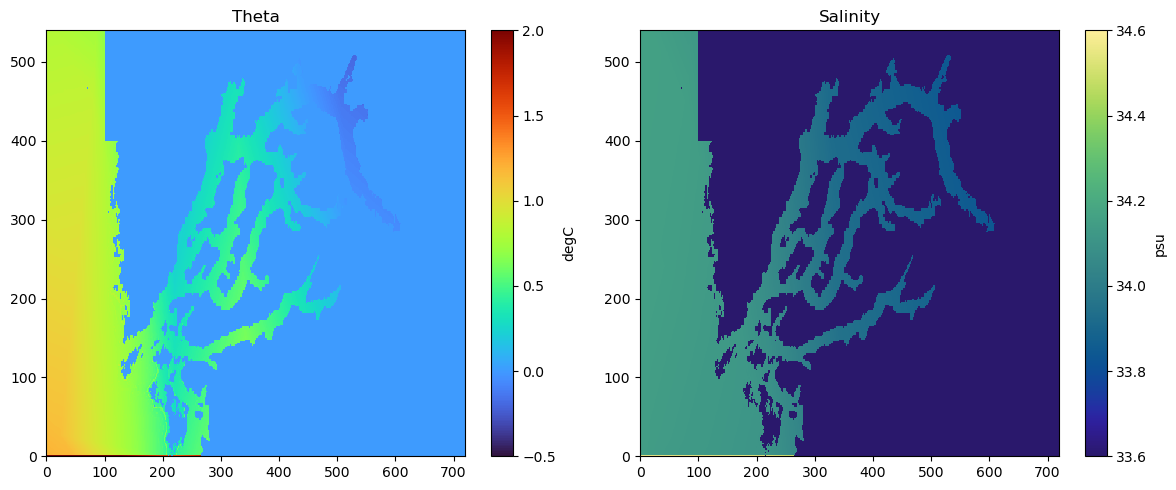

In [37]:
# sanity checking the theta and salt plots

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].pcolormesh(THETA[0, :, :], cmap='turbo', vmin=-0.5, vmax=2)
axes[0].set_title('Theta')
fig.colorbar(im0, ax=axes[0], label='degC')

im1 = axes[1].pcolormesh(SALT[0, :, :], cmap='cmo.haline', vmin=33.6, vmax=34.6)
axes[1].set_title('Salinity')
fig.colorbar(im1, ax=axes[1], label='psu')

plt.tight_layout()
plt.show()


In [38]:
# create a directory called 'plots' to put the following new files and movies into

plots_dir = os.path.join(lesson_folder, 'plots')
os.makedirs(plots_dir, exist_ok=True)

In [39]:
# THETA movie:

deltaT = 30  # seconds per timestep
start_datetime = datetime(2017, 1, 1)

file_list = []
num_timesteps = THETA.shape[0]

for n in range(num_timesteps):

    # read in iteration and print out model time in yyyy/mm/dd format onto the plot
    iteration = iters[n]
    model_seconds = int(iteration * deltaT)        
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')

    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f'T_surf_{iteration_str}.png')

    # mask the land 
    T = THETA[n, :, :]
    T_masked = np.ma.masked_where(land_mask, T)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(T_masked, cmap='turbo', vmin = -1, vmax = 3)
    plt.colorbar(label='degC')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Sea Surface Temperature – {date_str}')

    plt.savefig(image_path)
    plt.close(fig)

    file_list.append(image_path)

print("Number of frames:", len(file_list))

Number of frames: 533


In [40]:
fps=10

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'THETA.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/THETA.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/THETA.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/THETA.mp4


In [41]:
# SALT movie:

Salt_file_list = []
Salt_num_timesteps = SALT.shape[0]

for n in range(Salt_num_timesteps):
    
    iteration = iters[n]
    model_seconds = int(iteration * deltaT)        
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')

    
    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f'S_surf_{iteration_str}.png')

    S = SALT[n, :, :]
    S_masked = np.ma.masked_where(land_mask, S)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(S_masked, cmap='cmo.haline', vmin=33.6, vmax=34.6)
    plt.colorbar(label='psu')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'Salinity – {date_str}')

    plt.savefig(image_path)
    plt.close(fig)

    Salt_file_list.append(image_path)

print("Number of frames:", len(Salt_file_list))

Number of frames: 533


In [42]:
fps=5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(Salt_file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'SALT.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/SALT.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/SALT.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/SALT.mp4


In [43]:
# UVEL movie:

UVEL_file_list = []
UVEL_num_timesteps = UVEL.shape[0]


for n in range(UVEL_num_timesteps):
    
    iteration = iters[n]
    model_seconds = int(iteration * deltaT)        
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')

    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f'U_surf_{iteration_str}.png')

    U = UVEL[n, :, :]
    U_masked = np.ma.masked_where(land_mask, U)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(U_masked, cmap='seismic', vmin = -1, vmax = 1)
    plt.colorbar(label='m/s')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'UVEL – {date_str}')

    plt.savefig(image_path)
    plt.close(fig)

    UVEL_file_list.append(image_path)

print("Number of frames:", len(UVEL_file_list))

Number of frames: 533


In [44]:
fps=5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(UVEL_file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'UVEL.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/UVEL.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/UVEL.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/UVEL.mp4


In [45]:
# VVEL movie:

VVEL_file_list = []
VVEL_num_timesteps = UVEL.shape[0]

for n in range(VVEL_num_timesteps):

    iteration = iters[n]
    model_seconds = int(iteration * deltaT)        
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')

    iteration_str = '{:010d}'.format(iteration)

    image_path = os.path.join(plots_dir, f'U_surf_{iteration_str}.png')

    V = VVEL[n, :, :]
    V_masked = np.ma.masked_where(land_mask, V)

    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(V_masked, cmap='seismic', vmin = -1.5, vmax = 2.5)
    plt.colorbar(label='m/s')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f'VVEL – {date_str}')

    plt.savefig(image_path)
    plt.close(fig)

    VVEL_file_list.append(image_path)

print("Number of frames:", len(VVEL_file_list))

Number of frames: 533


In [46]:
fps=5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(VVEL_file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'VVEL.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/VVEL.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/VVEL.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/VVEL.mp4


In [47]:
# calculating vorticity! 

# size of earth 
Re = 6371000.0

# getting lat/lon from the grid
lat0 = np.nanmean(YC)
dlat = np.nanmean(np.diff(YC[:, 0]))
dlon = np.nanmean(np.diff(XC[0, :]))

# calculating the dx and dy for the vorticty calculations 
dy = (dlat * np.pi/180.0) * Re
dx = (dlon * np.pi/180.0) * Re * np.cos(np.deg2rad(lat0))

print("dx, dy ~", dx, dy)


dx, dy ~ 240.4279989360506 221.97802022763986


In [48]:
# vorticity movie:

vorticity_file_list = []
num_timesteps = UVEL.shape[0]

for n in range(num_timesteps):

    iteration = iters[n]
    model_seconds = int(iteration * deltaT)        
    frame_datetime = start_datetime + timedelta(seconds = model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')
    iteration_string = f"{iteration:010d}"

    image_path = os.path.join(plots_dir, f'vorticity_surf_{iteration_string}.png')

    U = UVEL[n, :, :]
    V = VVEL[n, :, :]

    # gradients 
    dVdy, dVdx = np.gradient(V, dy, dx)
    dUdy, dUdx = np.gradient(U, dy, dx)

    # vorticity z = dv/dx - du/dy
    vorticity = dVdx - dUdy

    # masking the land 
    vorticity_masked = np.ma.masked_where(land_mask, vorticity)


    # plotting
    fig = plt.figure(figsize=(10, 6))
    # plt.pcolormesh(vorticity_masked, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
    plt.pcolormesh(vorticity_masked, cmap='RdBu_r', vmin=-.0005, vmax=0.0005)
    plt.colorbar(label='Surface vorticity (s$^{-1}$)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f"Surface vorticity – {date_str}'")

    plt.savefig(image_path)
    plt.close(fig)

    vorticity_file_list.append(image_path)

print("Number of frames:", len(vorticity_file_list))

Number of frames: 533


In [49]:
fps=5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(vorticity_file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'vorticity.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/vorticity.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/vorticity.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/vorticity.mp4


In [50]:
# relative vorticity movie:

rel_vorticity_file_list = []
num_timesteps = UVEL.shape[0]

# coriolis parameter information 
Omega = 7.29e-5
lat0 = np.nanmean(YC)
f_coriolis = 2 * Omega * np.sin(np.deg2rad(lat0))

for n in range(num_timesteps):

    iteration = iters[n]

    # iter to date 
    model_seconds = int(iteration * deltaT)
    frame_datetime = start_datetime + timedelta(seconds=model_seconds)
    date_str = frame_datetime.strftime('%Y-%m-%d %H:%M')

    iteration_string = f"{iteration:010d}"
    image_path = os.path.join(plots_dir, f'rel_vorticity_surf_{iteration_string}.png')

    # gadient calucations
    U = UVEL[n, :, :]
    V = VVEL[n, :, :]

    dVdy, dVdx = np.gradient(V, dy, dx)
    dUdy, dUdx = np.gradient(U, dy, dx)

    rel_vorticity = dVdx - dUdy
    rel_vorticity_masked = np.ma.masked_where(land_mask, rel_vorticity)

    # plotting the relative vorticity 
    fig = plt.figure(figsize=(10, 6))
    plt.pcolormesh(rel_vorticity_masked, cmap='RdBu_r', vmin=-5e-4, vmax=5e-4)
    plt.colorbar(label='Surface relative vorticity ζ (s$^{-1}$)')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')
    plt.title(f"Surface Relative Vorticity – {date_str}")  
    plt.savefig(image_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

    rel_vorticity_file_list.append(image_path)

print("Number of frames:", len(rel_vorticity_file_list))

Number of frames: 533


In [51]:
fps=5

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(rel_vorticity_file_list, fps=fps)

output_file = os.path.join(lesson_folder, 'plots', 'rel_vorticity.mp4')
clip.write_videofile(output_file)

Moviepy - Building video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/rel_vorticity.mp4.
Moviepy - Writing video /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/rel_vorticity.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/plots/rel_vorticity.mp4


### ANALYSIS: 

To get a better sense of what’s happening at the surface across the whole fjord, I look at surface relative vorticity, since the mooring time series alone don’t capture the full spatial picture. Vorticity describes the spin or rotation of the surface flow and indicates whether currents are cyclonic or anticyclonic. In the vorticity movie, coherent eddies are clearly visible throughout the fjord, with many exhibiting cyclonic rotation. Most of these features are associated with positive vorticity, consistent with upward motion, suggesting that these eddies may play an important role in surface-driven mixing and vertical exchange.